In [1]:
import gc
import time
import argparse
from fastai.layers import swish

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from fastai.callback.schedule import Learner
from fastai.data.core import DataLoaders
from fastai.losses import L1LossFlat
from fastai.callback.core import Callback
from fastai.callback.tracker import ReduceLROnPlateau, SaveModelCallback

from HW_torch import dataLoads_build, net_parameter_count, hw_layer
from HW_base import evaluate_build, focus_build

In [2]:
fname               = 'F5'
epoch_num_first     = 100
batch_size_first    = 100
epoch_num_second    = 100
batch_size_second   = 500
evaluate_num        = 128
focus_min           = 0.6

In [3]:
class net_test(torch.nn.Module):
    def __init__(self, evaluate_dic_list, **kwargs):
        super(net_test, self).__init__()
        self.hw_layer = hw_layer(evaluate_dic_list)
        self.hw_dims = self.hw_layer.channels
        self.lstm1 = torch.nn.LSTM(self.hw_dims, self.hw_dims, bias=False, bidirectional=False, batch_first=True)
        self.lstm2 = torch.nn.LSTM(self.hw_dims, self.hw_dims, bias=False, bidirectional=False, batch_first=True)
        self.lstm3 = torch.nn.LSTM(self.hw_dims, self.hw_dims, bias=False, bidirectional=False, batch_first=True)
        self.lstm4 = torch.nn.LSTM(self.hw_dims, self.hw_dims, bias=False, bidirectional=False, batch_first=True)
        self.fc = torch.nn.Linear(self.hw_dims, 1, bias=True)
    def forward(self, x):
        hw = self.hw_layer(x)
        #lstm1
        x, _ = self.lstm1(hw)
        x = x * hw
        #lstm2
        x, _ = self.lstm2(x)
        x = x * hw
        #lstm3
        x, _ = self.lstm3(x)
        x = x * hw
        #lstm4
        x, _ = self.lstm4(x)
        x = x * hw
        #fc
        x = self.fc(x)
        return x

In [4]:
data_train_df = pd.read_csv('./Database/train.csv')
data_test_df = pd.read_csv('./Database/test.csv')

In [5]:
drop_columns = ['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2']
x_columns = [col for col in data_train_df.columns if col not in drop_columns]
y_columns = ['pressure']

In [6]:
data_train = data_train_df[x_columns].values.astype(np.float32)
data_train = data_train.reshape(-1, 80, data_train.shape[-1])

target_train = data_train_df[y_columns].values.astype(np.float32)
target_train = target_train.reshape(-1, 80, target_train.shape[-1])

data_test = data_test_df[x_columns].values.astype(np.float32)
data_test = data_test.reshape(-1, 80, data_test.shape[-1])

In [7]:
np.random.seed(121212)
data_idx = np.arange(len(data_train))
np.random.shuffle(data_idx)

train_index = data_idx[:int(len(data_idx)*0.8)]
valid_index = data_idx[int(len(data_idx)*0.8):]

In [8]:
x_train, y_train = data_train[train_index], target_train[train_index]
x_valid, y_valid = data_train[valid_index], target_train[valid_index]
x_test = data_test

In [9]:
del data_train_df
del data_test_df
gc.collect()

0

In [10]:
evaluate_list = [evaluate_build(x_test[..., i], evaluate_num) for i in range(x_test.shape[-1])]
evaluate_focus_list = []
for evaluate in evaluate_list:
    focus = 1 - (len(evaluate) - 1)/10
    if focus < focus_min:
        focus = focus_min
    evaluate_focus = focus_build(evaluate, focus)
    evaluate_focus_list.append(evaluate_focus)

evaluate_num:   3,focus:0.8000: 3it [00:00, ?it/s]
evaluate_num:   3,focus:0.8000: 3it [00:00, ?it/s]
evaluate_num: 127,focus:0.6000: 127it [00:00, 172.21it/s]
evaluate_num:  99,focus:0.6000: 99it [00:00, 136.15it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]


In [11]:
model = net_test(evaluate_focus_list)
print(model)

train_parameter_num, freeze_parameter_num = net_parameter_count(model)
print(train_parameter_num, freeze_parameter_num)

net_test(
  (hw_layer): hw_layer(
    (evaluate_list): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(3, 1)
      (2): Embedding(127, 1)
      (3): Embedding(99, 1)
      (4): Embedding(2, 1)
    )
    (focus_list): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(3, 1)
      (2): Embedding(127, 1)
      (3): Embedding(99, 1)
      (4): Embedding(2, 1)
    )
  )
  (lstm1): LSTM(234, 234, bias=False, batch_first=True)
  (lstm2): LSTM(234, 234, bias=False, batch_first=True)
  (lstm3): LSTM(234, 234, bias=False, batch_first=True)
  (lstm4): LSTM(234, 234, bias=False, batch_first=True)
  (fc): Linear(in_features=234, out_features=1, bias=True)
)
1752427 468


epoch,train_loss,valid_loss,time
0,11.194911,11.173380,00:33
1,10.896135,10.759493,00:33
2,10.316748,10.247281,00:33
3,9.661553,9.625765,00:33
4,8.898375,8.797651,00:33
5,7.821251,7.719182,00:33
6,6.531657,6.383805,00:33
7,5.213272,5.162981,00:33
8,4.592368,4.603078,00:32
9,4.147915,4.067479,00:32


Epoch 29: reducing lr to 0.00019781622388674128
Epoch 39: reducing lr to 0.00018090596753759738
Epoch 49: reducing lr to 0.00015000651348627807
Epoch 59: reducing lr to 0.00011046063150918881
Epoch 69: reducing lr to 6.910620955419162e-05
Epoch 79: reducing lr to 3.3093767598933495e-05
Epoch 89: reducing lr to 8.650184982654887e-06
Epoch 99: reducing lr to 2.0002413089574567e-09


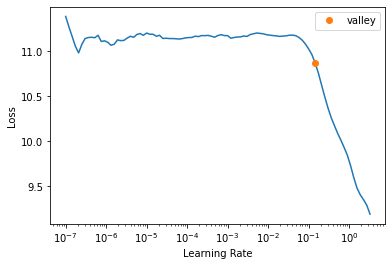

In [12]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_first)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_first, lr_max=2e-3, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10))

epoch,train_loss,valid_loss,time
0,0.273466,0.328060,00:33
1,0.269089,0.328351,00:33
2,0.273649,0.328867,00:33
3,0.273024,0.328056,00:33
4,0.272983,0.328158,00:32
5,0.273197,0.328512,00:33
6,0.270672,0.328889,00:33
7,0.271405,0.328506,00:33
8,0.270412,0.328577,00:33
9,0.272130,0.328027,00:33


Better model found at epoch 0 with valid_loss value: 0.32806047797203064.
Better model found at epoch 3 with valid_loss value: 0.3280561864376068.
Better model found at epoch 9 with valid_loss value: 0.32802680134773254.
Epoch 10: reducing lr to 1.1644253059708985e-05
Better model found at epoch 12 with valid_loss value: 0.3277709484100342.
Epoch 20: reducing lr to 2.106133958125738e-05
Epoch 30: reducing lr to 3.5689766932233896e-05
Epoch 40: reducing lr to 5.4610377263457244e-05
Epoch 50: reducing lr to 7.663432340316964e-05
Epoch 60: reducing lr to 0.00010037774722633229
Epoch 70: reducing lr to 0.00012434877041851675
Epoch 80: reducing lr to 0.0001470412221267514
Epoch 90: reducing lr to 0.00016702921910879376
Epoch 100: reducing lr to 0.00018305686009266058


KeyboardInterrupt: 

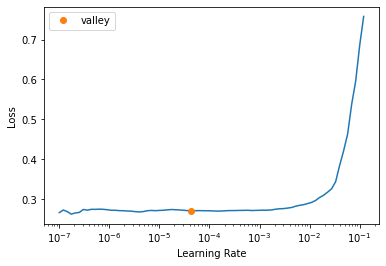

In [13]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_second)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_second, lr_max=2e-3, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10),
                                                        SaveModelCallback(monitor='valid_loss', fname=f'{fname}_best')])

In [14]:
from HW_torch import torch_valid, torch_predict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

state_dict = torch.load(f'models/{fname}_best.pth')
model.load_state_dict(state_dict)

loss = torch_valid([model.to(device)], L1LossFlat(), (x_train, y_train),  batch_size_second, to_device=device)
valid_loss = torch_valid([model.to(device)], L1LossFlat(), (x_valid, y_valid),  batch_size_second, to_device=device)

print(loss, valid_loss)

0.27023134020385364 0.327769149218174


In [15]:
predict = torch_predict([model.to(device)], x_test, batch_size_second, to_device=device)
predict = np.reshape(predict, (-1))

prodict: 100% 503/503 [00:07<00:00, 63.32it/s]


In [16]:
df = pd.read_csv('Database/sample_submission.csv', index_col=0)
df['pressure'] = predict

df.to_csv(f'Submission/{fname}.csv')